In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, log_loss
from sklearn.inspection import DecisionBoundaryDisplay

# Task 1

### Loading Data

#### Train


In [4]:
train = pd.read_csv('train.csv')
x, y = train['Text'], train['Category']

# Encode the target variable
train_y = LabelEncoder().fit_transform(y)

# Vectorize the text
cv = CountVectorizer()
train_x = cv.fit_transform(x)
feature_names = cv.get_feature_names_out()
train_x = pd.DataFrame(train_x.toarray(), columns=feature_names)

#### Test


In [5]:
test = pd.read_csv('test.csv')
x, y = test['Text'], test['Category']

# Encode the target variable
test_y = LabelEncoder().fit_transform(y)

# Vectorize the text
cv = CountVectorizer(vocabulary=feature_names)
test_x = cv.fit_transform(x)
test_x = pd.DataFrame(test_x.toarray(), columns=feature_names)

### Example Articles

In [23]:
print(f'Number of Articles: {train_x.shape[0]}')
print(f'Number of Features: {train_x.shape[1]}')   

example = train.join(train_x)
example.head()

Number of Articles: 428
Number of Features: 13518


,ArticleId,Text,Category,00,000,000th,001st,0051,007,0100,...,zola,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zooropa,zorro
0,1976,lifestyle governs mobile choice faster better ...,tech,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1797,french honour director parker british film dir...,entertainment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1866,fockers fuel festive film chart comedy meet fo...,entertainment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1153,housewives lift channel 4 ratings debut us tel...,entertainment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,342,u2 desire number one u2 three prestigious gram...,entertainment,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Top-50 Term Frequency Distribution

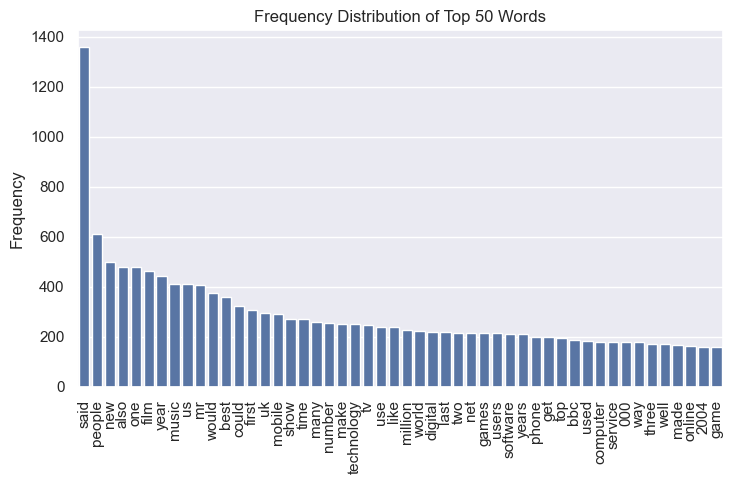

In [45]:
word_totals = train_x.sum(axis=0)
top_50 = word_totals.sort_values(ascending=False).head(50)

sns.set_theme(rc={'figure.figsize':(7.5,5)})
sns.barplot(top_50)
plt.xticks(rotation=90)
plt.title('Frequency Distribution of Top 50 Words')
plt.ylabel('Frequency')
plt.tight_layout()

The above plot shows the top 50 most frequent words in the training dataset.

### Term Frequency Distribution by Class

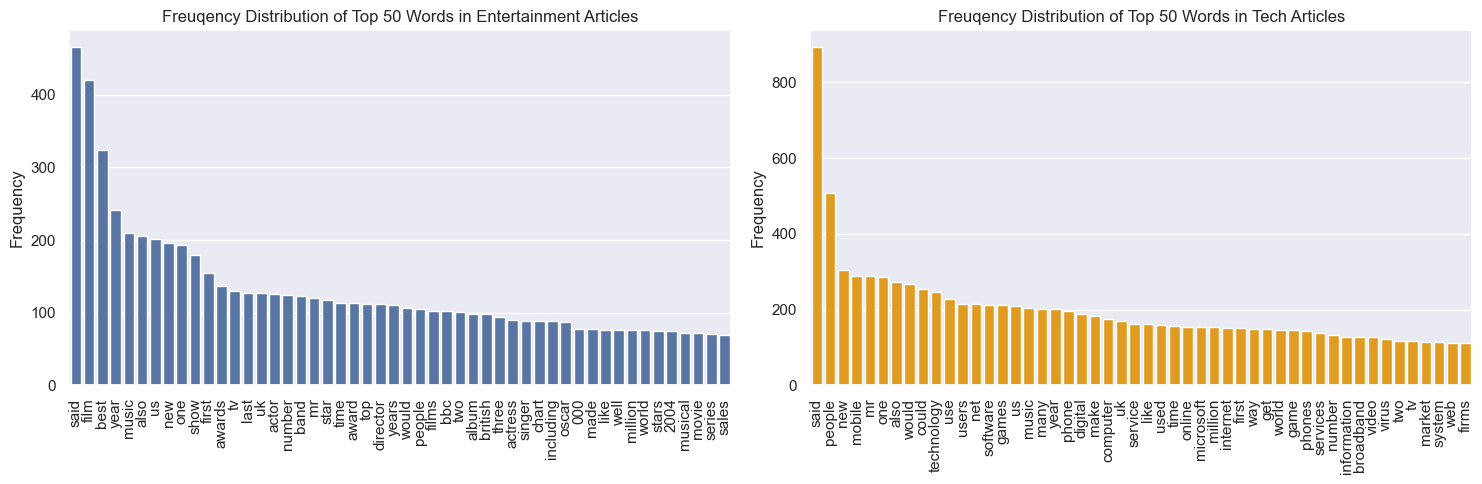

In [50]:
totals_by_class = train_x.groupby(train_y)

entertainment, tech = [df.sum(numeric_only=True) for _, df in totals_by_class]
entertainment.sort_values(ascending=False, inplace=True)
tech.sort_values(ascending=False, inplace=True)

sns.set_theme(rc={'figure.figsize':(15,5)})

plt.subplot(1, 2, 1)
sns.barplot(entertainment.head(50))
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Freuqency Distribution of Top 50 Words in Entertainment Articles')

plt.subplot(1, 2, 2)
sns.barplot(tech.head(50), color='orange')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Freuqency Distribution of Top 50 Words in Tech Articles')

plt.tight_layout()

The above chart shows the top 50 most frequent words in entertainment articles on the left and the top 50 most frequent words in tech articles on the right.

### Class Distribution

Text(0.5, 1.0, 'Class Distribution')

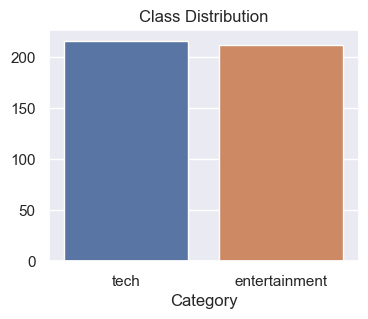

In [51]:
class_counts = train['Category'].value_counts()

sns.set_theme(rc={'figure.figsize':(4,3)})
sns.barplot(x = class_counts.index, y = class_counts.values, hue=class_counts.index)
plt.title('Class Distribution')

The above plot shows the distribution of classes within the training data. The distribution is basically equal.

# Task 2

### Naive Bayes

In [7]:
x_train, y_train, x_test, y_test = train_x, train_y, test_x, test_y

In [42]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

print("Most likely tech words")
print(nb.feature_names_in_[np.argsort(nb.feature_log_prob_[1,:])[-20:]])
print("\nMost likely entertainment words")
print(nb.feature_names_in_[np.argsort(nb.feature_log_prob_[0,:])[-20:]])

def tech_ratio(x):
    return np.divide(x[0,:],x[1,:])

print("\nBest ratio tech words")
print(nb.feature_names_in_[np.argsort(tech_ratio(nb.feature_log_prob_))[-20:]])
print("\nBest ratio entertainment words")
print(nb.feature_names_in_[np.argsort(tech_ratio(nb.feature_log_prob_))[:20][::-1]])


Most likely tech words
['phone' 'year' 'many' 'music' 'us' 'games' 'software' 'net' 'users' 'use'
 'technology' 'could' 'would' 'also' 'one' 'mr' 'mobile' 'new' 'people'
 'said']

Most likely entertainment words
['star' 'mr' 'band' 'number' 'actor' 'uk' 'last' 'tv' 'awards' 'first'
 'show' 'one' 'new' 'us' 'also' 'music' 'year' 'best' 'film' 'said']

Best ratio tech words
['machines' 'windows' 'gadgets' 'mobiles' 'consumer' 'phone' 'gadget'
 'games' 'spam' 'phones' 'technology' 'pc' 'net' 'firms' 'virus'
 'broadband' 'microsoft' 'mobile' 'software' 'users']

Best ratio entertainment words
['film' 'singles' 'comedy' 'starring' 'oscars' 'foxx' 'charles'
 'nominations' 'rock' 'festival' 'actor' 'nominated' 'chart' 'aviator'
 'album' 'stars' 'band' 'oscar' 'singer' 'actress']


### K-Nearest Neighbours

Text(0.5, 1.0, '1-NN Surface Plot')

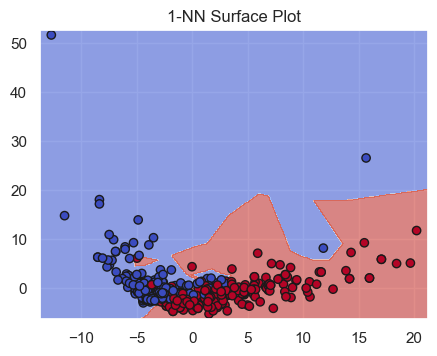

In [97]:
pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(x_train)

knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=2)
knn.fit(x_train_pca, y_train)

sns.set_theme(rc={'figure.figsize':(5,3.75)})
surface_plot_display = DecisionBoundaryDisplay.from_estimator(knn, x_train_pca, grid_resolution=400, plot_method='contourf',
    response_method='predict', cmap = 'coolwarm', alpha = 0.6)
surface_plot_display.ax_.scatter(x_train_pca[:,0], x_train_pca[:,1], c=y_train, cmap='coolwarm', edgecolor="k")
plt.title("1-NN Surface Plot")

### Support Vector Machine

### Soft Margin SVM

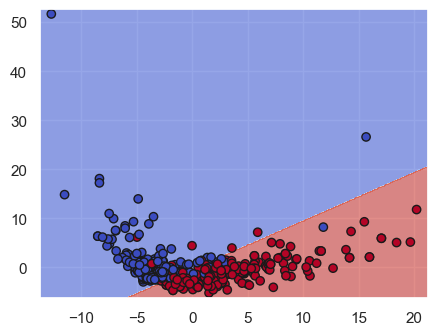

In [58]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
svm = SVC(kernel='linear', C=1.0)
svm.fit(x_train_pca, y_train)

sns.set_theme(rc={'figure.figsize':(5,3.75)})
surface_plot_display = DecisionBoundaryDisplay.from_estimator(svm, x_train_pca, grid_resolution=400, 
    plot_method='contourf', response_method='predict', cmap = 'coolwarm', alpha = 0.6)
surface_plot_display.ax_.scatter(x_train_pca[:,0], x_train_pca[:,1], c=y_train, cmap='coolwarm', edgecolor="k")

### Hard Margin RBF Kernel SVM

c:\Users\adamk\OneDrive - The University of Auckland\COMPSCI 361\CS361-A3\venv\lib\site-packages\sklearn\inspection\_plot\decision_boundary.py:191: UserWarning: The following kwargs were not used by contour: 'gamma'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


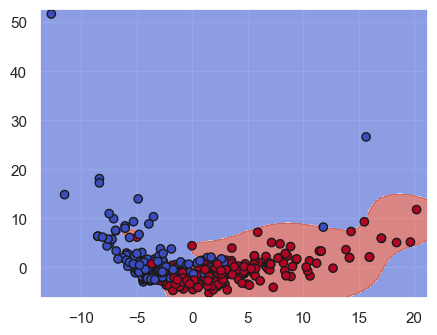

In [60]:

pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(x_train)

hm_svm = SVC(kernel='rbf', C=10**10)
hm_svm.fit(x_train_pca, y_train)

sns.set_theme(rc={'figure.figsize':(5,3.75)})
surface_plot_display = DecisionBoundaryDisplay.from_estimator(hm_svm, x_train_pca, 
    grid_resolution=400, plot_method='contourf', response_method='predict', cmap = 'coolwarm', alpha = 0.6, gamma='scale')
surface_plot_display.ax_.scatter(x_train_pca[:,0], x_train_pca[:,1], c=y_train, cmap='coolwarm', edgecolor="k")

### Neural Network

c:\Users\adamk\OneDrive - The University of Auckland\COMPSCI 361\CS361-A3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adamk\OneDrive - The University of Auckland\COMPSCI 361\CS361-A3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\adamk\OneDrive - The University of Auckland\COMPSCI 361\CS361-A3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Text(0.5, 1.0, 'Cross entropy loss versus number of hidden units for a NN')

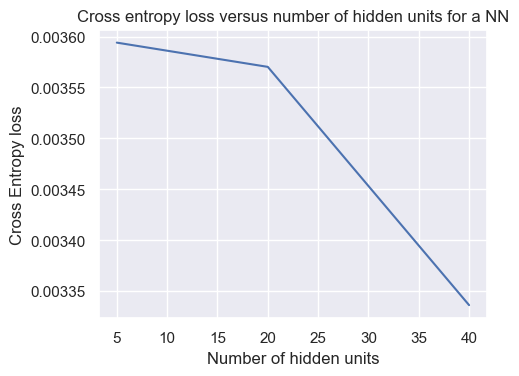

In [61]:
import random
random.seed(69)

hidden_units_list = [5, 20, 40]
cross_entropy_losses = [0]*len(hidden_units_list)
nn = MLPClassifier(
    random_state=420,
    solver = 'sgd',
    learning_rate='constant',
    learning_rate_init=0.01,
    max_iter=100
)
for i, hidden_units in enumerate(hidden_units_list):
    nn.set_params(hidden_layer_sizes = hidden_units, max_iter = 1)
    # Set up a dummy fit to change the weights
    nn.fit([[0]], [1])
    # Create our initial weights:
    nn.set_params(max_iter = 100)
    nn.coefs_ = [np.array([random.uniform(0,0.1) for _ in range(hidden_units)]) for k in range(2)]
    nn.intercepts_ = [random.uniform(0,0.1) for _ in range(2)]

    nn.fit(x_train, y_train)
    cross_entropy_losses[i] = log_loss(y_train, nn.predict_proba(x_train), normalize=True)

sns.set_theme(rc={'figure.figsize':(5,3.75)})
plt.plot(hidden_units_list, cross_entropy_losses)
plt.xlabel("Number of hidden units")
plt.ylabel("Cross Entropy loss")
plt.title("Cross entropy loss versus number of hidden units for a NN")

# Task 3

In [1]:
# part a
def plot_f1score_against_train_size(model, m_array = [0.1, 0.3, 0.5, 0.7, 0.9]):
    x_train_size = x_train.shape[0]
    train_accuracy, test_accuracy = [0]*len(m_array), [0]*len(m_array)
    for i, m in enumerate(m_array):
        iter_size = round(m*x_train_size)
        model.fit(x_train.head(iter_size), y_train[:iter_size])
        train_accuracy[i] = f1_score(y_train[:iter_size], model.predict(x_train.head(iter_size)))
        test_accuracy[i] = f1_score(y_test, model.predict(x_test))
    plt.plot(m_array, train_accuracy)
    plt.plot(m_array, test_accuracy)
    plt.legend(['Train', 'Test'])
    

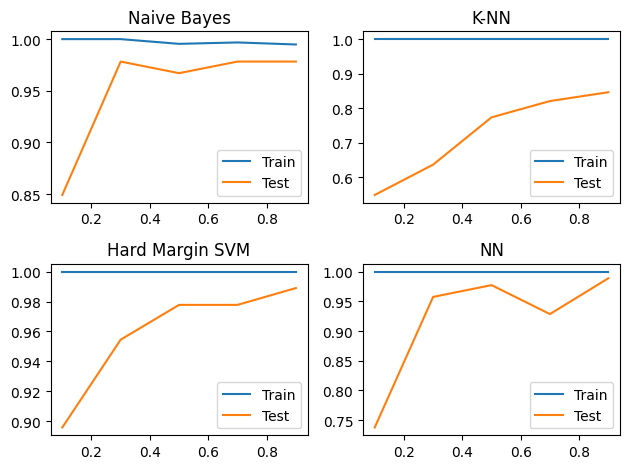

In [8]:
plt.subplot(2,2,1)
plot_f1score_against_train_size(MultinomialNB())
plt.title("Naive Bayes")
plt.subplot(2,2,2)
plot_f1score_against_train_size(KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=2))
plt.title("K-NN")
plt.subplot(2,2,3)
plot_f1score_against_train_size(SVC(kernel='rbf', C=10**10))
plt.title("Hard Margin SVM")
plt.subplot(2,2,4)
plot_f1score_against_train_size(MLPClassifier(learning_rate='constant', learning_rate_init=0.01, max_iter=100))
plt.title("NN")
plt.tight_layout()

In [36]:
# Task 3 b)
'''
Hyperparameters for each model
Naive Bayes: alpha
kNN: neighbours, distance metric
SVM: kernel, gamma for rbf
NN: depth, iterations, step_size
'''
from sklearn.model_selection import cross_validate
def five_fold(model, name):
    result = cross_validate(model, train_x, train_y, cv=5, scoring=['f1'], return_train_score=True)
    train_acc = sum(result['train_f1'])/5
    test_acc = sum(result['test_f1'])/5
    print(f"Train F1 Score of {name} : {train_acc}")
    print(f"Test F1 Score of {name} : {test_acc}")

In [37]:
five_fold(MultinomialNB(alpha = 0.01), 'Naive Bayes with alpha 0.01')
print()
five_fold(MultinomialNB(alpha = 0.5), 'Naive Bayes with alpha 0.5')
print()
five_fold(MultinomialNB(alpha = 1), 'Naive Bayes with alpha 1')
print()
five_fold(MultinomialNB(alpha = 4), 'Naive Bayes with alpha 4')

Train F1 Score of Naive Bayes with alpha 0.01 : 0.9982574893311362
Test F1 Score of Naive Bayes with alpha 0.01 : 0.9861534349104518

Train F1 Score of Naive Bayes with alpha 0.5 : 0.9976777791862087
Test F1 Score of Naive Bayes with alpha 0.5 : 0.9835261771107803

Train F1 Score of Naive Bayes with alpha 1 : 0.9965250510908937
Test F1 Score of Naive Bayes with alpha 1 : 0.9812852807522369

Train F1 Score of Naive Bayes with alpha 4 : 0.994795935141718
Test F1 Score of Naive Bayes with alpha 4 : 0.9751775797494512


In [38]:
five_fold(KNeighborsClassifier(n_neighbors=1, metric='euclidean'), 'kNN with 1 neighbours, euclidean distance')
print()
five_fold(KNeighborsClassifier(n_neighbors=3, metric='euclidean'), 'kNN with 3 neighbours, euclidean distance')
print()
five_fold(KNeighborsClassifier(n_neighbors=5, metric='euclidean'), 'kNN with 5 neighbours, euclidean distance')
print()
five_fold(KNeighborsClassifier(n_neighbors=1, metric='manhattan'), 'kNN with 1 neighbours, manhattan distance')
print()
five_fold(KNeighborsClassifier(n_neighbors=3, metric='manhattan'), 'kNN with 3 neighbours, manhattan distance')
print()
five_fold(KNeighborsClassifier(n_neighbors=5, metric='manhattan'), 'kNN with 5 neighbours, manhattan distance')

Train F1 Score of kNN with 1 neighbours, euclidean distance : 1.0
Test F1 Score of kNN with 1 neighbours, euclidean distance : 0.8029596920864528

Train F1 Score of kNN with 3 neighbours, euclidean distance : 0.8197479637252941
Test F1 Score of kNN with 3 neighbours, euclidean distance : 0.6464235384165147

Train F1 Score of kNN with 5 neighbours, euclidean distance : 0.7103244491607663
Test F1 Score of kNN with 5 neighbours, euclidean distance : 0.613483938106106

Train F1 Score of kNN with 1 neighbours, manhattan distance : 1.0
Test F1 Score of kNN with 1 neighbours, manhattan distance : 0.7214955471164284

Train F1 Score of kNN with 3 neighbours, manhattan distance : 0.8008565608183666
Test F1 Score of kNN with 3 neighbours, manhattan distance : 0.6042579827084728

Train F1 Score of kNN with 5 neighbours, manhattan distance : 0.6717132561898972
Test F1 Score of kNN with 5 neighbours, manhattan distance : 0.47349585401212624


In [39]:
five_fold(SVC(kernel='linear', C=0.001), 'Soft-margin linear SVM with penalty 0.001')
print()
five_fold(SVC(kernel='linear', C=1.0), 'Soft-margin linear SVM with penalty 1.0')
print()
five_fold(SVC(kernel='linear', C=100000000000), 'Soft-margin linear SVM with penalty 100000000000')

Train F1 Score of Soft-margin linear SVM with penalty 0.001 : 0.9906535045095733
Test F1 Score of Soft-margin linear SVM with penalty 0.001 : 0.9564238937379379

Train F1 Score of Soft-margin linear SVM with penalty 1.0 : 1.0
Test F1 Score of Soft-margin linear SVM with penalty 1.0 : 0.964365070208526

Train F1 Score of Soft-margin linear SVM with penalty 100000000000 : 1.0
Test F1 Score of Soft-margin linear SVM with penalty 100000000000 : 0.964365070208526


In [40]:
five_fold(SVC(kernel='rbf', C = float(10**10), gamma = 1), 'Hard-margin RBF SVM with gamma 1')
print()
five_fold(SVC(kernel='rbf', C = float(10**10), gamma = 0.01), 'Hard-margin RBF SVM with gamma 0.01')
print()
five_fold(SVC(kernel='rbf', C = float(10**10), gamma = 0.0001), 'Hard-margin RBF SVM with gamma 0.0001')
print()
five_fold(SVC(kernel='rbf', C = float(10**10), gamma = 0.000001), 'Hard-margin RBF SVM with gamma 0.000001')

Train F1 Score of Hard-margin RBF SVM with gamma 1 : 1.0
Test F1 Score of Hard-margin RBF SVM with gamma 1 : 0.29223529411764704

Train F1 Score of Hard-margin RBF SVM with gamma 0.01 : 1.0
Test F1 Score of Hard-margin RBF SVM with gamma 0.01 : 0.8321341324421851

Train F1 Score of Hard-margin RBF SVM with gamma 0.0001 : 1.0
Test F1 Score of Hard-margin RBF SVM with gamma 0.0001 : 0.9717067516661837

Train F1 Score of Hard-margin RBF SVM with gamma 0.000001 : 1.0
Test F1 Score of Hard-margin RBF SVM with gamma 0.000001 : 0.964365070208526


In [41]:
five_fold(MLPClassifier(learning_rate_init = 0.01, max_iter = 100, random_state = 39),'NN with 1 hidden layer of 100 hidden unit, learning rate 0.01, max iter 100')
print()
five_fold(MLPClassifier(learning_rate_init = 0.01, max_iter = 200, random_state = 39),'NN with 1 hidden layer of 100 hidden unit, learning rate 0.01, max iter 200')
print()
five_fold(MLPClassifier(learning_rate_init = 0.001, max_iter = 100, random_state = 39),'NN with 1 hidden layer of 100 hidden unit, learning rate 0.001, max iter 100')
print()
five_fold(MLPClassifier(learning_rate_init = 0.01, max_iter = 100, hidden_layer_sizes = (50,), random_state = 39),'NN with 1 hidden layer of 50 hidden unit, learning rate 0.01, max iter 100')
print()
five_fold(MLPClassifier(learning_rate_init = 0.01, max_iter = 100, hidden_layer_sizes = (50,50), random_state = 39),'NN with 2 hidden layer of 50 hidden unit, learning rate 0.01, max iter 100')
print()
five_fold(MLPClassifier(learning_rate_init = 0.01, max_iter = 100, hidden_layer_sizes = (50,50,50), random_state = 39),'NN with 3 hidden layer of 50 hidden unit, learning rate 0.01, max iter 100')
print()
five_fold(MLPClassifier(learning_rate_init = 0.01, max_iter = 100, hidden_layer_sizes = (50,50,50,50), random_state = 39),'NN with 4 hidden layer of 50 hidden unit, learning rate 0.01, max iter 100')
print()
five_fold(MLPClassifier(learning_rate_init = 0.01, max_iter = 100, hidden_layer_sizes = (50,50,50,50,50), random_state = 39),'NN with 5 hidden layer of 50 hidden unit, learning rate 0.01, max iter 100')
print()
five_fold(MLPClassifier(learning_rate_init = 0.001, max_iter = 100, hidden_layer_sizes = (50,50), random_state = 39),'NN with 2 hidden layer of 50 hidden unit, learning rate 0.001, max iter 100')


Train F1 Score of NN with 1 hidden layer of 100 hidden unit, learning rate 0.01, max iter 100 : 1.0
Test F1 Score of NN with 1 hidden layer of 100 hidden unit, learning rate 0.01, max iter 100 : 0.9275583346042398

Train F1 Score of NN with 1 hidden layer of 100 hidden unit, learning rate 0.01, max iter 200 : 1.0
Test F1 Score of NN with 1 hidden layer of 100 hidden unit, learning rate 0.01, max iter 200 : 0.9275583346042398

Train F1 Score of NN with 1 hidden layer of 100 hidden unit, learning rate 0.001, max iter 100 : 1.0
Test F1 Score of NN with 1 hidden layer of 100 hidden unit, learning rate 0.001, max iter 100 : 0.9835274799575002

Train F1 Score of NN with 1 hidden layer of 50 hidden unit, learning rate 0.01, max iter 100 : 1.0
Test F1 Score of NN with 1 hidden layer of 50 hidden unit, learning rate 0.01, max iter 100 : 0.9536719001441305

Train F1 Score of NN with 2 hidden layer of 50 hidden unit, learning rate 0.01, max iter 100 : 1.0
Test F1 Score of NN with 2 hidden layer o

--------------------
NB: hyperparameter - alpha  
.   Best score at alpha 0.01 (score: 0.9861534349104518)
    
kNN: hyperparameter - neighbours, distance metric  
.   Overall score is quite low, I think this is because size of the train data is too small - kNN has the worst score when the size of train data is small at Task 3 a.  
.   Euclidean distance metric is better then manhattan distance when number of neighbour is same.  
.   Less neighbour is better. underfit with 3 and 5
.   Best score at 1 neighbours, euclidean distance (score: 0.8029596920864528)
    
soft-margin SVM: hyperparameter - penalty  
.   Didn't effect a lot unless very low(0.001) penalty (score got decreased a bit)  
.   Best score at penalty 1 (score: 0.964365070208526)

Hard-margin RBF SVM: hyperparameter - gamma  
.   Better score with lower gamma
.   Best score at gamma 0.000001 (score: 0.9717067516661837)

NN: hyperparameter - number of hidden layer, number of hidden unit for each layer, max iteration, learning late  
.   It affected a bit by random chance. So not very confident about the result  
.   Increasing iteration didn't effect the score, I think because it converged before reach 100 iteration.  
.   Decreasing learning rate increased score a lot, but slower.   
.   50 hidden unit was better than 100 hidden unit (both 1 hidden layer)  
.   Number of hidden layer didn't effect much.  
.   Best score at 2 hidden layer of 50 hidden unit, learning rate 0.001, max iter 100 (score: 0.9860408489414576)

In [194]:
#task 3 c

NB_t3c = MultinomialNB(alpha = 0.01)
kNN_t3c = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
SVM_t3c = SVC(kernel='rbf', C = float(10**10), gamma = 0.0001)
NN_t3c = MLPClassifier(learning_rate_init = 0.001, max_iter = 100, hidden_layer_sizes = (50,50), random_state = 39)

NB_t3c.fit(train_x,train_y)
kNN_t3c.fit(train_x,train_y)
SVM_t3c.fit(train_x,train_y)
NN_t3c.fit(train_x,train_y)

NB_f1 = f1_score(test_y, NB_t3c.predict(test_x))
kNN_f1 = f1_score(test_y, kNN_t3c.predict(test_x))
SVM_f1 = f1_score(test_y, SVM_t3c.predict(test_x))
NN_f1 = f1_score(test_y, NN_t3c.predict(test_x))

print(f"F1 Score of NB : {NB_f1}, hyperparameter setting: alpha 0.01")
print(f"F1 Score of kNN : {kNN_f1}, hyperparameter setting: 1 neighbour, euclidean distance metric")
print(f"F1 Score of SVM : {SVM_f1}, hyperparameter setting: Hard-margin RBF, gamma 0.0001")
print(f"F1 Score of NN : {NN_f1}, hyperparameter setting: 2 hidden layers with 50 hidden unit each, learning rate 0.001, max iteration 100")

F1 Score of NB : 0.9782608695652174, hyperparameter setting: alpha 0.01
F1 Score of kNN : 0.875, hyperparameter setting: 1 neighbour, euclidean distance metric
F1 Score of SVM : 1.0, hyperparameter setting: Hard-margin RBF, gamma 0.0001
F1 Score of NN : 1.0, hyperparameter setting: 2 hidden layers with 50 hidden unit each, learning rate 0.001, max iteration 100
